In [1]:
from TicTacToe import TicTacToe
from Players import RandomPlayer, RandomWinner, RandomWinnerBlocker
from functools import lru_cache
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
p1 = RandomPlayer('O')
p2 = RandomPlayer('X')

game = TicTacToe()
p1_next=True

while True:
    if p1_next:
        p1.move(game)
    else:
        p2.move(game)
        
    p1_next = not p1_next
    
    if game.game_over():
        game.print_board()

        print('game over')
        break
    if game.winner():
        game.print_board()

        print(f"Winner: {game.winner()}")
        break
    



|O X|
|O  |
|OX |


Winner: O


In [9]:
@lru_cache
def get_state_key(states):
    return sorted(states)[0]


def decide_next_move(board: TicTacToe, state_dict: dict, player='X'):

    possible_moves = board.possible_moves()
    outcomes = []
    for move in possible_moves:
        hyp_state = board.fake_move(player=player, index=move)
        hyp_key = get_state_key(game.similar_states(curr_state=hyp_state))

        if hyp_key in state_dict:
            outcomes.append(state_dict[hyp_key][0])
        elif board.winner(curr_state=hyp_key) == player:
            # next move would win
            outcomes.append(1)
        elif board.winner(curr_state=hyp_key):
            # next move would lose
            outcomes.append(0)
            pass
        elif board.moves == 8:
            # next move would end in draw
            outcomes.append(0)
        else:
            # not seen before, default to 0.5
            outcomes.append(0.5)

    best_outcome = np.max(outcomes)
    best_indexes = [idx for idx, outcome in enumerate(outcomes) if outcome == best_outcome]
    best_index = random.choice(best_indexes)

    if board.state[possible_moves[best_index]]!=' ':
        print(1)
    return possible_moves[best_index]
    


In [10]:
def play_game(player_type):
    player = 'X'
    num_games = 10000
    state_dict = dict()
    wld = []

    """
    state_dict looks like 
    {'state1': [probability, num_wins, num]}
    """
    for game_num in range(1, num_games+1):
        # print(game_num)

        state_moves = []
        game = TicTacToe()
        p2 = player_type(player='O')

        if random.randint(0,1):
            # other player goes first
            # print('2 going first')
            game = p2.move(game)
        
        p1_turn = True

        while not game.game_over() and not game.winner():

            if p1_turn:
                next_move = decide_next_move(board=game, state_dict=state_dict, player=player)
                state_moves.append(game.fake_move(player=player, index=next_move))

                game.add_move(player=player, index=next_move)
            else:
                game = p2.move(game)

            # game.print_board()
            p1_turn = not p1_turn

        # gameover
        if game.winner() == player:
            # we won
            increment = 1
            wld.append('w')
        elif game.winner() is False:
            # game was a draw
            increment = 0 
            wld.append('d')
        else:
            # we lost 
            wld.append('l')
            increment = 0 


        for state in state_moves:
            str_state = ''.join(state)
            state_key = get_state_key(game.similar_states(str_state))
            if state_key in state_dict:
                prob, won, played = state_dict[state_key]
                new_won = won + increment
                new_played = played + 1

                state_dict[state_key] = [new_won/new_played, new_won, new_played]
                
            else:
                state_dict[state_key] = [increment, increment, 1]


    # game.print_board()
    # for k,v in state_dict.items():
    #     print(k,v)

    ws = np.cumsum([1 if x=='w' else 0 for x in wld ])
    ds = np.cumsum([1 if x=='l' else 0 for x in wld ])
    ls = np.cumsum([1 if x=='d' else 0 for x in wld ])


    print(f"W: {ws[-1]}, D: {ds[-1]}, L: {ls[-1]}")

        
    fig, ax = plt.subplots(1)
    ax.plot(ws,label='w')
    ax.plot(ds,label='d')
    ax.plot(ls,label='l')

    plt.legend()

    return state_dict





W: 8852, D: 956, L: 192


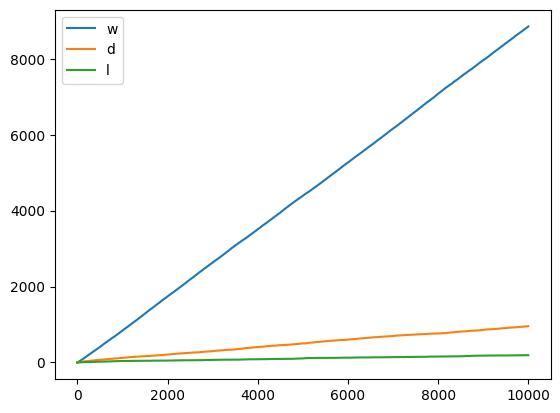

In [11]:
rp_sd = play_game(player_type=RandomPlayer)
# rpw_sd = play_game(player_type=RandomWinner)
# rpwb_sd = play_game(player_type=RandomWinnerBlocker)


In [ ]:
import pandas as pd

rpwb_sd

In [ ]:
df = pd.DataFrame(rpwb_sd).T
df.index[-1]

In [ ]:
# current state of board
# decide next move, record state and move
# make move, and other makes move, check if w/l/end
# update state dict with plays 